In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, exp, sin
from scipy import fft

In [2]:
filter_el = np.load("1000X1000X2000Filter.npy")

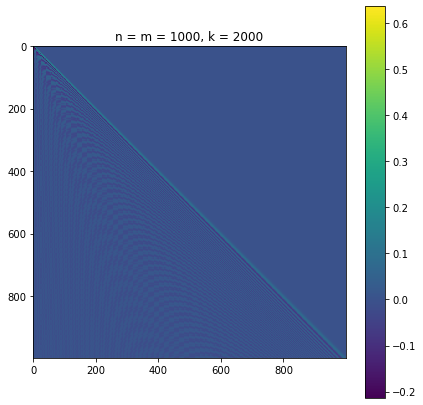

In [3]:
plt.figure(figsize=(7,9),)
plt.title("n = m = 1000, k = 2000")
plt.imshow(filter_el,interpolation='none')
plt.colorbar(shrink=0.8)
plt.show()

In [4]:
def sinc(x):
    if x == 0:
        return 1
    else:
        return sin(x)/x

# 1D Modeling


## Source Modifying

In [91]:
original_time_array = np.linspace(0, 0.1, 101)
original_dt = 0.1 /  100
original_vibration_array = (1 - 2 * (pi * f_m * (original_time_array-t_0))**2) * np.exp(-1 * (pi * f_m * (original_time_array-t_0))**2)
original_derivative = -1 * (-4 * (pi * f_m * (original_time_array-t_0)) * pi * f_m * \
                         np.exp(-1 * ( pi * f_m * (original_time_array-t_0))**2) + \
                         (1 - 2 * (pi * f_m * (original_time_array-t_0))**2) * \
                         np.exp(-1 * ( pi * f_m * (original_time_array-t_0))**2) * \
                            -2 * (pi * f_m * (original_time_array-t_0)) * pi * f_m)
derivative_max = np.max(original_derivative)
original_derivative = original_derivative / derivative_max
correction_time_array = np.linspace(0, 0.1, 101)
correction_dt = 0.1 / 100

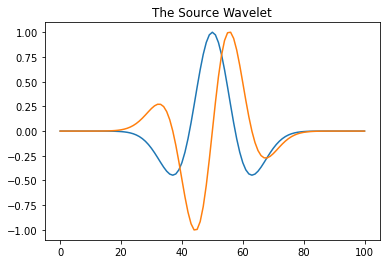

In [92]:
plt.plot(original_time_array * 1000, original_vibration_array)
plt.plot(original_time_array * 1000, original_derivative)
plt.title('The Source Wavelet')
plt.show()

In [93]:
def Source_Correctiion(original_time_array, original_dt, original_source_array, correction_time_array, correction_dt):
    # Forward Transform
    
    omega_range =  pi / original_dt
    omega_array = np.linspace(-omega_range, omega_range, original_time_array.size+1)
    domega = 2 * pi / (original_dt * original_time_array.size)
    
    aux_array = np.zeros(omega_array.size, dtype=complex)
    for index, item in enumerate(omega_array):
        tmp = np.exp(complex(0,1) * item * sinc(item * original_dt * 0.5) * original_time_array) * original_source_array * original_dt
        aux_array[index] = tmp.sum()
        
    # Inverse Transform
    correction_vibration_array = np.zeros(correction_time_array.size, dtype=complex)
    
    for index, item in enumerate(correction_time_array):
        tmp = np.exp(-1 * complex(0,1) * omega_array * item) * aux_array * domega
        correction_vibration_array[index] = tmp.sum()
        
    correction_vibration_array = correction_vibration_array.real * 0.5 / pi
    
    return correction_vibration_array

In [94]:
function_correction_vibration = Source_Correctiion(original_time_array, original_dt, original_vibration_array, correction_time_array, correction_dt)

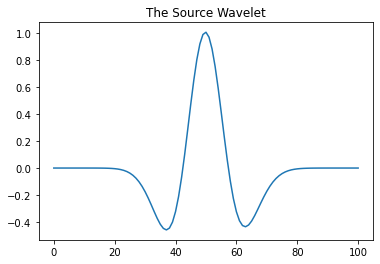

In [95]:
plt.plot(correction_time_array * 1000, function_correction_vibration)
plt.title('The Source Wavelet')
plt.show()

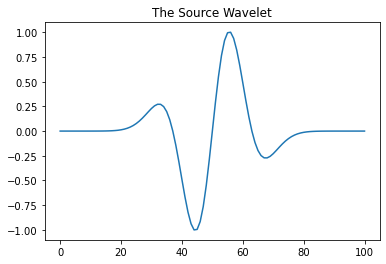

In [96]:
plt.plot(original_time_array * 1000, original_derivative)
plt.title('The Source Wavelet')
plt.show()

In [97]:
function_correction_derivative = Source_Correctiion(original_time_array, original_dt, original_derivative, correction_time_array, correction_dt)

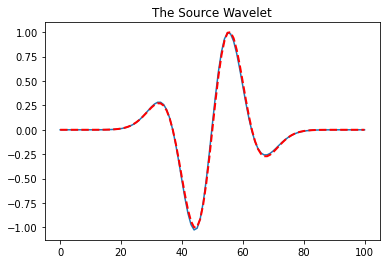

In [98]:
plt.plot(correction_time_array * 1000, function_correction_derivative)
plt.plot(original_time_array * 1000, original_derivative, ls='--', color='r', lw=2)
# plt.plot(correction_time_array * 1000, original_derivative)
plt.title('The Source Wavelet')
plt.show()

## 1-D FD Modeling

In [140]:
fd_dx = 5
fd_dt = 0.001
fd_velocity = 3000
fd_nx = 3000
fd_nt = 1000
fd_source_position = 1500
fd_u_all = np.zeros((fd_nx, fd_nt), dtype=float)
fd_time_array = np.arange(0, 1, fd_dt) 
fd_kernal = np.array([1,-2,1])
fd_constant = fd_velocity ** 2 * fd_dt ** 2 / fd_dx ** 2

In [141]:
for index, item in enumerate(fd_time_array):
    if index > 1:
        fd_u_all[:, index] = fd_constant * np.convolve(fd_u_all[:,index-1], fd_kernal, mode='same') - \
                             fd_u_all[:,index-2] + 2 * fd_u_all[:,index-1]
    if index < function_correction_derivative.size:
        fd_u_all[fd_source_position, index] -= function_correction_derivative[index]

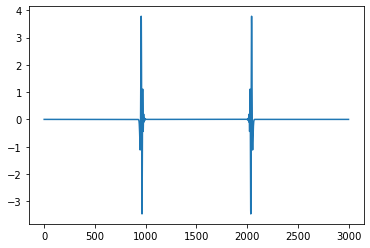

In [142]:
plt.plot(fd_u_all[:,960])
plt.show()

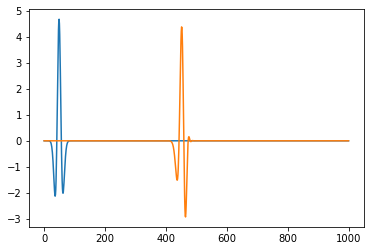

In [147]:
plt.plot(fd_u_all[1500,:])
plt.plot(fd_u_all[1740,:])
plt.show()

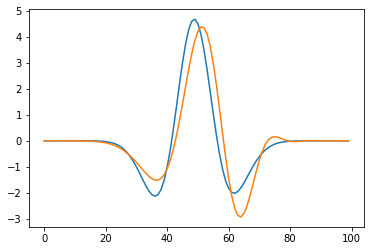

In [148]:
plt.plot(fd_u_all[1500,0:100])
plt.plot(fd_u_all[1740,400:500])
plt.show()

In [150]:
et_record = np.dot(filter_el, fd_u_all[1740,:])

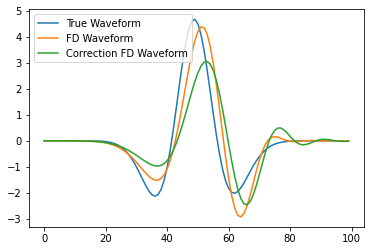

In [152]:
plt.plot(fd_u_all[1500,0:100], label='True Waveform')
plt.plot(fd_u_all[1740,400:500], label='FD Waveform')
plt.plot(et_record[400:500], label='Correction FD Waveform')
plt.legend()
plt.show()

In [153]:
def Wave_Correctiion(original_time_array, original_dt, original_source_array, correction_time_array, correction_dt):
    # Forward Transform
    
    omega_range =  pi / original_dt
    omega_array = np.linspace(-omega_range, omega_range, original_time_array.size+1)
    domega = 2 * pi / (original_dt * original_time_array.size)
    
    aux_array = np.zeros(omega_array.size, dtype=complex)
    for index, item in enumerate(omega_array):
        tmp = np.exp(complex(0,1) * item * sinc(item * original_dt * 0.5) * original_time_array) * original_source_array * original_dt
        aux_array[index] = tmp.sum()
        
    # Inverse Transform
    correction_vibration_array = np.zeros(correction_time_array.size, dtype=complex)
    
    for index, item in enumerate(correction_time_array):
        tmp = np.exp(-1 * complex(0,1) * omega_array * item) * aux_array * domega * np.cos(omega_array * original_dt * 0.5)
        correction_vibration_array[index] = tmp.sum()
        
    correction_vibration_array = correction_vibration_array.real * 0.5 / pi
    
    return correction_vibration_array

In [154]:
function_cor = Wave_Correctiion(fd_time_array, fd_dt, fd_u_all[1740,:], fd_time_array, fd_dt)

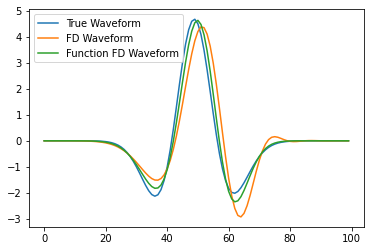

In [157]:
plt.plot(fd_u_all[1500,0:100], label='True Waveform')
plt.plot(fd_u_all[1740,400:500], label='FD Waveform')
# plt.plot(et_record[400:500], label='Correction FD Waveform')
plt.plot(function_cor[400:500], label='Function FD Waveform')
plt.legend()
plt.show()

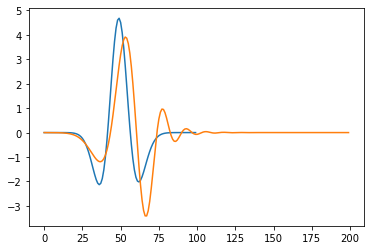

In [160]:
plt.plot(fd_u_all[1500,0:100])
plt.plot(fd_u_all[1980,800:1000])
plt.show()

In [165]:
cor_1980 = Wave_Correctiion(fd_time_array, fd_dt, fd_u_all[1980,:], fd_time_array, fd_dt)
filter_1980 = np.dot(filter_el, fd_u_all[1980,:])

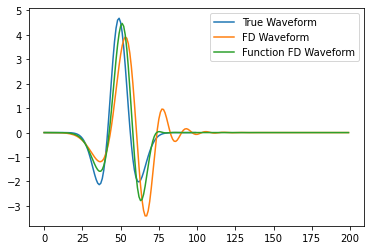

In [169]:
plt.plot(fd_u_all[1500,0:100], label='True Waveform')
plt.plot(fd_u_all[1980,800:1000], label='FD Waveform')
# plt.plot(filter_1980[800:1000], label='Correction FD Waveform')
plt.plot(cor_1980[800:1000], label='Function FD Waveform')
plt.legend()
plt.show()

## 1-D FD Modeling, low accuracy

In [170]:
fd_dx_low = 10
fd_dt_low = 0.001
fd_velocity_low = 3000
fd_nx_low = 1000
fd_nt_low = 1000
fd_source_position_low = 500
fd_u_all_low = np.zeros((fd_nx_low, fd_nt_low), dtype=float)
fd_time_array_low = np.arange(0, 1, fd_dt_low) 
fd_kernal_low = np.array([1,-2,1])
fd_constant_low = fd_velocity_low ** 2 * fd_dt ** 2 / fd_dx ** 2

In [171]:
for index, item in enumerate(fd_time_array):
    if index > 1:
        fd_u_all_low[:, index] = fd_constant_low * np.convolve(fd_u_all_low[:,index-1], fd_kernal_low, mode='same') - \
                             fd_u_all_low[:,index-2] + 2 * fd_u_all_low[:,index-1]
    if index < function_correction_derivative.size:
        fd_u_all_low[fd_source_position_low, index] -= function_correction_derivative[index]

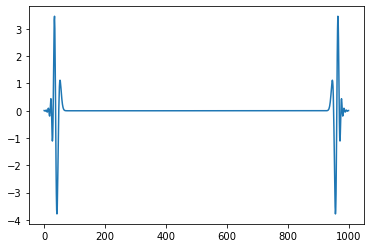

In [173]:
plt.plot(fd_u_all_low[:,960])
plt.show()

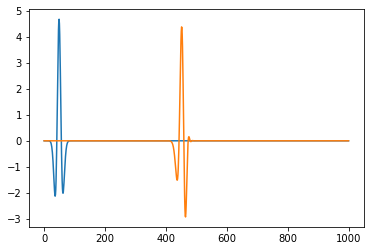

In [175]:
plt.plot(fd_u_all_low[500,:])
plt.plot(fd_u_all_low[740,:])
plt.show()

In [177]:
function_cor_low = Wave_Correctiion(fd_time_array_low, fd_dt_low, fd_u_all_low[740,:], fd_time_array_low, fd_dt_low)

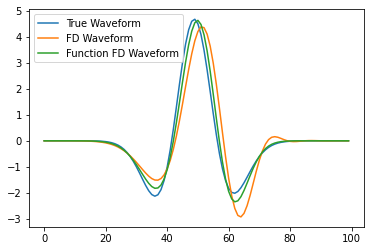

In [181]:
plt.plot(fd_u_all_low[500,0:100], label='True Waveform')
plt.plot(fd_u_all_low[740,400:500], label='FD Waveform')
# plt.plot(filter_1980[800:1000], label='Correction FD Waveform')
plt.plot(function_cor_low[400:500], label='Function FD Waveform')
plt.legend()
plt.show()